# Ejercicio 2 — Predicción de consumo de gas (t+1 a t+7)

En este ejercicio construimos un flujo completo de **predicción de consumo de gas a 7 días** combinando datos históricos de consumo y variables meteorológicas. Trabajamos en dos fases de modelado con **TensorFlow-Keras**:  
1) **Modelo base con lags** del consumo.  
2) **Modelo extendido** añadiendo variables meteorológicas sincronizadas en la misma ventana temporal.

Además, realizamos una **integración y limpieza** de datos por fecha, un **análisis temporal** (tendencia y estacionalidad) y calculamos **ACF/PACF** para seleccionar lags informativos. Finalmente, **comparamos MAE y RMSE** de ambos modelos y generamos un pronóstico a 7 días.

## Índice de pasos
1. Preparación del entorno e importaciones
2. Rutas y estructura mínima del ejercicio
3. Datos de entrada (Previsualización)
4. Integración y limpieza (consumo + meteorología)
5. Análisis temporal (tendencia, estacionalidad, correlaciones)
6. ACF/PACF y selección de lags
7. Confección del dataset supervisado (ventanas)
8. Modelo base (lags de consumo) — Keras Functional
9. Modelo extendido (lags + meteorología) — Keras Functional
10. Evaluación (MAE, RMSE), pronóstico a 7 días y conclusiones.
11. Anexo - Variables de calendario.
12.Comparativa final
13.Despliegue del modelo (FastAPI + Swagger)

## 1.Preparación del entorno e importaciones

Centralizamos aquí todas las librerías que usaremos:
- **pandas/numpy**: manipulación y álgebra básica.  
- **matplotlib**: gráficos simples.  
- **statsmodels**: ACF/PACF y descomposición estacional.  
- **scikit-learn**: métricas (MAE/RMSE) y utilidades.  
- **TensorFlow/Keras**: construcción de redes (LSTM/CNN 1D) con la **API funcional**.


In [ ]:
# Importaciones centrales
import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import json

# ACF/PACF y descomposición
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf as sm_acf, pacf as sm_pacf

# Métricas y utilidades
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Deep Learning (Keras - API funcional)
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Reproducibilidad básica
np.random.seed(42)
tf.random.set_seed(42)

## 2.Rutas, estructura y README (trabajo en Drive y entrega portable)

Trabajamos habitualmente en **Google Drive** (`USE_DRIVE=True`), pero preparamos también el **modo entrega** con rutas **relativas** (`USE_DRIVE=False`) para que el cuaderno sea **portable** y se pueda **re-ejecutar** sin depender de Drive.

Estructura creada:
- `notebooks/`, `src/`, `scripts/` (aquí dejaremos el **.py** exportado)
- `data/raw/` (CSV de entrada: `Consumption.csv`, `Meteorological_data_anon.csv`)
- `data/processed/` (integración diaria ya limpia)
- `outputs/models/` (si guardamos modelos)
- `outputs/figures/` (ACF/PACF, estacionalidad/semana, etc.)
- `outputs/csv/` (comparativas, métricas, predicciones t+1…t+7)
- `outputs/docs/` (aquí guardaremos el **PDF** del informe)

El README indica dónde colocar **datos**,y qué salidas se generan.

In [ ]:
#Rutas + estructura + README
USE_DRIVE = True  #True (monta Drive)
                   #False (rutas relativas)

if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except Exception as e:
        print("Aviso: no se pudo montar Drive (¿no estás en Colab?).", e)
    ROOT = Path("/content/drive/MyDrive/MASTER BIG DATA/md2_2025")
    EJ2  = ROOT / "ej2_prediccion_gas"
else:
    here = Path(".").resolve()
    EJ2  = here if (here.name == "ej2_prediccion_gas") else (here / "ej2_prediccion_gas")

PATHS = {
    "root":           str(EJ2.parent),
    "ej2":            str(EJ2),
    "nb":             str(EJ2 / "notebooks"),
    "src":            str(EJ2 / "src"),
    "scripts":        str(EJ2 / "scripts"),                 # .py exportado
    "data_raw":       str(EJ2 / "data" / "raw"),
    "data_processed": str(EJ2 / "data" / "processed"),
    "out_models":     str(EJ2 / "outputs" / "models"),
    "out_figs":       str(EJ2 / "outputs" / "figures"),
    "out_csv":        str(EJ2 / "outputs" / "csv"),
    "out_docs":       str(EJ2 / "outputs" / "docs"),        # PDF del informe
}

def ensure_dir(p: str): Path(p).mkdir(parents=True, exist_ok=True)
for k in ("nb","src","scripts","data_raw","data_processed","out_models","out_figs","out_csv","out_docs"):
    ensure_dir(PATHS[k])

# README
readme = Path(PATHS["ej2"]) / "README.md"
if not readme.exists():
    readme.write_text("""# Ejercicio 2 — Predicción de consumo de gas (t+1…t+7)

**Objetivo.** Predecimos el consumo de gas a 7 días combinando lags del consumo, variables meteorológicas y calendario.

**Notebook principal:** `notebooks/ej2_prediccion.ipynb`

## Datos (no incluidos en el ZIP)
Copiar estos CSV en `data/raw/`:
- `Consumption.csv`
- `Meteorological_data_anon.csv`

## Salidas
- `data/processed/` → dataset diario integrado y limpio
- `outputs/csv/`    → comparativas (MAE, RMSE), predicciones t+1…t+7, tablas auxiliares
- `outputs/figures/`→ ACF/PACF, estacionalidad/semana, correlaciones, etc.
- `outputs/models/` → (opcional) modelos guardados
- `outputs/docs/`   → informe en **PDF** del notebook

## Modo entrega
- Ejecutar con `USE_DRIVE=False`
- En el notebook, usar:
  - `RUN_MODELING = False` → no reentrena; cargamos comparativas y métricas guardadas
  - `RECALC_TEST  = False` → no recalcula pronósticos; lee los ya guardados

## Requisitos
- Python 3.10+, `pandas`, `numpy`, `matplotlib`, `statsmodels`, `scikit-learn`, `tensorflow/keras`, `holidays`
""", encoding="utf-8")
    print("README creado:", readme)
else:
    print("README ya existe: no se modifica.")

print("Rutas clave:")
for k in ("data_raw","data_processed","out_csv","out_figs","out_models","out_docs","scripts"):
    print(f"  {k:>15} → {PATHS[k]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
README ya existe: no se modifica.
Rutas clave:
         data_raw → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/data/raw
   data_processed → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/data/processed
          out_csv → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/outputs/csv
         out_figs → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/outputs/figures
       out_models → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/outputs/models
         out_docs → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/outputs/docs
          scripts → /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/scripts


### 2.1Modo de ejecución

Usamos una bandera para controlar si entrenamos o **cargamos artefactos ya guardados** (CSV/JSON con métricas y predicciones).

- **`RUN_MODELING = True` (trabajo):** reentrenamos los modelos y **sobrescribimos** los archivos en `outputs/csv/` (p. ej., `base_pred_test.csv`, `ext_pred_test.csv`, etc.).
- **`RUN_MODELING = False` (entrega):** **no** entrenamos; **leemos** los artefactos guardados y mostramos exactamente los mismos números que en la ejecución previa.

Con esto las conclusiones del informe son **reproducibles** en la entrega, sin depender de volver a ajustar los modelos.

In [ ]:
# === Modo de ejecución (entrega vs. trabajo) ===
RUN_MODELING = False   # Entrega: False → NO entrena; usaremos CSV/artefactos guardados

## 3.Previsualización de datos.

Cargamos `Consumption.csv` y `Meteorological_data_anon.csv` tal cual están en `data/raw/` y mostramos:
- dimensiones (filas, columnas),
- nombres de columnas,
- un vistazo a las primeras y últimas filas,
- recuento rápido de nulos por columna,
- y, si existe una columna de fecha (`fecha`, `date`, `datetime` o `day`), el rango temporal detectado.

In [ ]:
raw_dir = Path(PATHS["data_raw"])
consumo_path = raw_dir / "Consumption.csv"
meteo_path   = raw_dir / "Meteorological_data_anon.csv"

def preview_df(df: pd.DataFrame, nombre: str):
    print(f"\n=== {nombre} ===")
    print("Shape:", df.shape)
    print("Columnas:", list(df.columns))

    # Rango temporal si hay columna de fecha común
    fecha_col = None
    for c in df.columns:
        cl = c.strip().lower()
        if cl in ("fecha", "date", "datetime", "day"):
            fecha_col = c
            break
    if fecha_col is not None:
        fechas = pd.to_datetime(df[fecha_col], errors="coerce")
        print("Rango de fechas:", fechas.min(), "→", fechas.max())
        print("Nulos en fecha:", int(fechas.isna().sum()))

    # Nulos por columna (top 6)
    print("Nulos por columna (top 6):")
    print(df.isna().sum().sort_values(ascending=False).head(6))

    # Muestras de datos
    print("\nPrimeras 5 filas:")
    print(df.head(5).to_string(index=False))
    print("\nÚltimas 5 filas:")
    print(df.tail(5).to_string(index=False))

# Carga simple (sin transformar)
df_consumo = pd.read_csv(consumo_path)
df_meteo   = pd.read_csv(meteo_path)

preview_df(df_consumo, "Consumption.csv")
preview_df(df_meteo,   "Meteorological_data_anon.csv")


=== Consumption.csv ===
Shape: (1581, 2)
Columnas: ['date_local_int', 'Consumption']
Nulos por columna (top 6):
date_local_int    0
Consumption       0
dtype: int64

Primeras 5 filas:
 date_local_int  Consumption
       20180901       552.80
       20180902       542.74
       20180903       616.59
       20180904       632.25
       20180905       640.30

Últimas 5 filas:
 date_local_int  Consumption
       20221227        499.0
       20221228        497.0
       20221229        491.0
       20221230        445.0
       20221231        384.0

=== Meteorological_data_anon.csv ===
Shape: (37993, 9)
Columnas: ['datetime_utc', 'local_datetime', 'date_local_int', 'hora', 'tamax', 'tamin', 'prec', 'vmax', 'inso']
Nulos por columna (top 6):
vmax            1490
tamin           1385
tamax           1385
inso            1368
prec            1353
datetime_utc       0
dtype: int64

Primeras 5 filas:
             datetime_utc            local_datetime  date_local_int  hora  tamax  tamin  prec  

## 4.Integración diaria y normalización de variables

Unificamos el consumo diario con la meteorología (agregada de horario a diario). Estandarizamos nombres y tipos para trabajar con una tabla diaria única.

- **Consumo:** `fecha`, `consumo`.
- **Meteo diaria:** `tmed`, `tmax_dia`, `tmin_dia`, `prec_dia`, `vmax_dia`, `inso_dia`.
- **Tabla final:** unión interna por `fecha`, ordenada y sin duplicados.

In [ ]:
# Rutas de entrada
raw_dir = Path(PATHS["data_raw"])
consumo_path = raw_dir / "Consumption.csv"
meteo_path   = raw_dir / "Meteorological_data_anon.csv"

# --- Consumo (diario) ---
df_consumo = pd.read_csv(consumo_path)
# Convertimos la fecha que viene como entero YYYYMMDD
df_consumo["fecha"] = pd.to_datetime(df_consumo["date_local_int"].astype(str), format="%Y%m%d")
df_consumo = (
    df_consumo
    .rename(columns={"Consumption": "consumo"})
    [["fecha", "consumo"]]
    .sort_values("fecha")
    .reset_index(drop=True)
)

# --- Meteo (horaria -> diaria) ---
df_meteo_h = pd.read_csv(meteo_path)

# Aseguramos tipos numéricos por si hubiera cadenas
for c in ["tamax", "tamin", "prec", "vmax", "inso"]:
    df_meteo_h[c] = pd.to_numeric(df_meteo_h[c], errors="coerce")

# Fecha diaria
df_meteo_h["fecha"] = pd.to_datetime(df_meteo_h["date_local_int"].astype(str), format="%Y%m%d")

# Temperatura media horaria y agregación diaria
df_meteo_h["tavg_hora"] = (df_meteo_h["tamax"] + df_meteo_h["tamin"]) / 2.0

df_meteo_d = (
    df_meteo_h
    .groupby("fecha", as_index=False)
    .agg(
        tmed=("tavg_hora", "mean"),
        tmax_dia=("tamax", "max"),
        tmin_dia=("tamin", "min"),
        prec_dia=("prec", "sum"),
        vmax_dia=("vmax", "max"),
        inso_dia=("inso", "sum"),
    )
    .sort_values("fecha")
    .reset_index(drop=True)
)

# --- Unión consumo + meteo (diaria) ---
df_daily = (
    df_consumo
    .merge(df_meteo_d, on="fecha", how="inner")
    .drop_duplicates(subset=["fecha"])
    .sort_values("fecha")
    .reset_index(drop=True)
)

# Vista rápida
print("df_consumo:", df_consumo.shape, "| columnas:", list(df_consumo.columns))
print("df_meteo_d:", df_meteo_d.shape, "| columnas:", list(df_meteo_d.columns))
print("df_daily  :", df_daily.shape,   "| columnas:", list(df_daily.columns))

print("\nRango de fechas (final):", df_daily["fecha"].min().date(), "→", df_daily["fecha"].max().date())
print("Nulos por columna (top 6):")
print(df_daily.isna().sum().sort_values(ascending=False).head(6))

print("\nPrimeras 5 filas de df_daily:")
print(df_daily.head(5).to_string(index=False))

df_consumo: (1581, 2) | columnas: ['fecha', 'consumo']
df_meteo_d: (1583, 7) | columnas: ['fecha', 'tmed', 'tmax_dia', 'tmin_dia', 'prec_dia', 'vmax_dia', 'inso_dia']
df_daily  : (1581, 8) | columnas: ['fecha', 'consumo', 'tmed', 'tmax_dia', 'tmin_dia', 'prec_dia', 'vmax_dia', 'inso_dia']

Rango de fechas (final): 2018-09-01 → 2022-12-31
Nulos por columna (top 6):
tmax_dia    32
tmed        32
vmax_dia    32
tmin_dia    32
fecha        0
consumo      0
dtype: int64

Primeras 5 filas de df_daily:
     fecha  consumo      tmed  tmax_dia  tmin_dia  prec_dia  vmax_dia  inso_dia
2018-09-01   552.80 24.689583      26.2      22.4       1.0       9.8      47.0
2018-09-02   542.74 25.443750      28.0      22.5       0.0      10.3     342.0
2018-09-03   616.59 26.087500      28.8      23.3       0.0       9.3     313.0
2018-09-04   632.25 25.535417      28.2      23.2       1.5       9.8     505.0
2018-09-05   640.30 24.618750      27.7      21.2       0.0      12.9     336.0


En este paso unificamos el consumo diario con la meteorología agregada a frecuencia diaria:

- **Consumo (`df_consumo`)**: convertimos `date_local_int` a `fecha` y renombramos `Consumption` → `consumo` → `(1581, 2)`.
- **Meteo diaria (`df_meteo_d`)**: a partir de datos horarios, calculamos por día:
  - `tmed` = media de la temperatura media horaria `((tamax + tamin)/2)`,
  - `tmax_dia` = máximo de `tamax`,
  - `tmin_dia` = mínimo de `tamin`,
  - `prec_dia` = suma de `prec`,
  - `vmax_dia` = máximo de `vmax`,
  - `inso_dia` = suma de `inso` → `(1583, 7)`.
- **Tabla final (`df_daily`)**: unión interna por `fecha`, ordenada y sin duplicados → `(1581, 8)`.

**Qué observamos**
- **Rango temporal**: 2018-09-01 → 2022-12-31 (coherente entre consumo y meteo).
- **Nulos**: 32 valores faltantes en variables meteo (`tmed`, `tmax_dia`, `tmin_dia`, `vmax_dia`); sin nulos en `fecha` ni `consumo`.
- **Muestra (primeras filas)**: las columnas y magnitudes son razonables para análisis temporal y creación de lags.

Antes del modelado decidiremos cómo tratar los 32 nulos de meteo.

### 4.1.Tratamiento de nulos en meteorología.

Imputamos únicamente las variables meteorológicas con una **media móvil de 7 días (ventana hacia atrás)**. De este modo aprovechamos la estacionalidad semanal y evitamos usar información “del futuro”. Si quedara algún nulo en los extremos, completamos con **forward/back fill**. La columna `consumo` no se toca.

In [ ]:
# Imputación causal (solo pasado) con media móvil 7 días en meteo
import pandas as pd

df_daily = df_daily.sort_values("fecha").reset_index(drop=True)

meteo_cols = ["tmed", "tmax_dia", "tmin_dia", "prec_dia", "vmax_dia", "inso_dia"]

print("Nulos antes de imputar:")
print(df_daily[meteo_cols].isna().sum().sort_values(ascending=False))

for c in meteo_cols:
    s = df_daily[c]
    # Media móvil CAUSAL (usa solo días previos): ventana 7, min 1
    ma7 = s.rolling(window=7, min_periods=1).mean()
    # Imputación + relleno de bordes sin usar 'method='
    df_daily[c] = s.where(s.notna(), ma7).ffill().bfill()

print("\nNulos después de imputar:")
print(df_daily[meteo_cols].isna().sum().sort_values(ascending=False))

Nulos antes de imputar:
tmed        32
tmax_dia    32
tmin_dia    32
vmax_dia    32
prec_dia     0
inso_dia     0
dtype: int64

Nulos después de imputar:
tmed        0
tmax_dia    0
tmin_dia    0
prec_dia    0
vmax_dia    0
inso_dia    0
dtype: int64


## 5.Análisis temporal (tendencia, estacionalidad y correlaciones)

Objetivo: entender la dinámica del consumo y su relación con la meteorología antes de seleccionar lags.
- Serie y medias móviles (7 y 30 días).
- Estacionalidad semanal (media por día de la semana).
- Estacionalidad anual (media por mes).
- Correlaciones (Pearson) entre `consumo` y variables meteo.

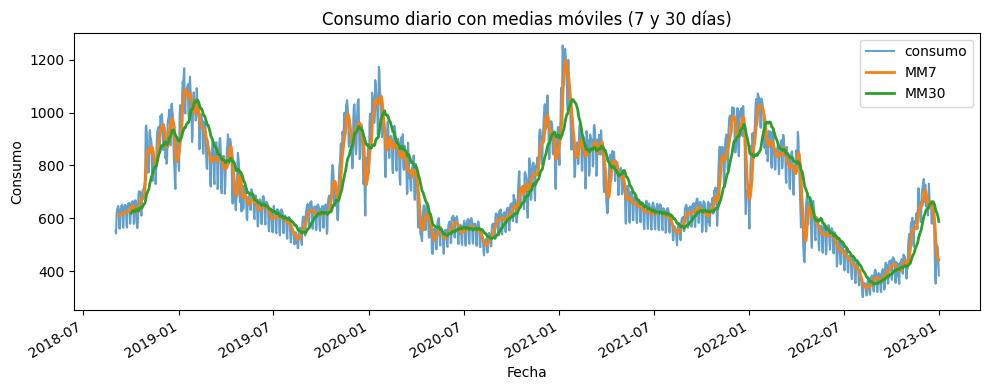

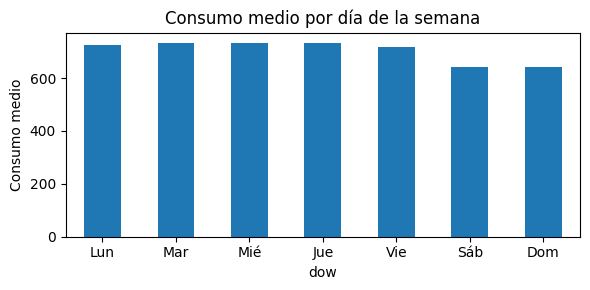

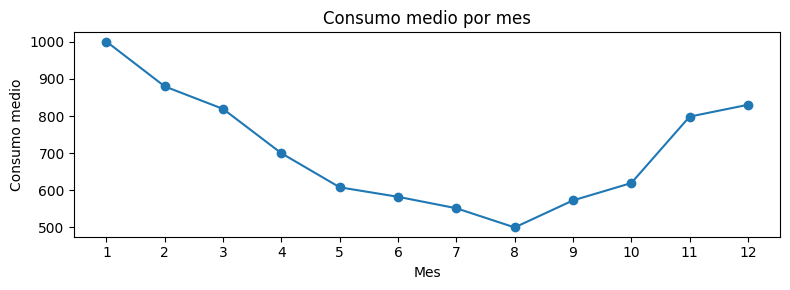

Correlaciones de Pearson respecto a 'consumo':

vmax_dia    0.113316
prec_dia    0.023260
inso_dia   -0.356680
tmax_dia   -0.789686
tmin_dia   -0.803873
tmed       -0.815311
Name: consumo, dtype: float64


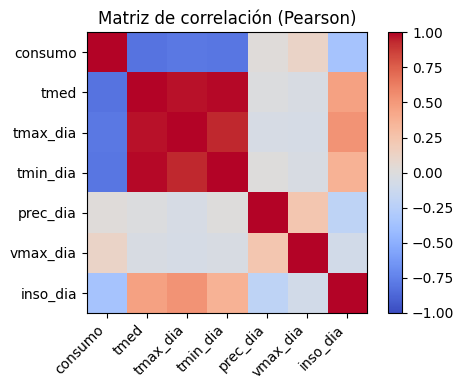


Figuras guardadas en: /content/ej2_prediccion_gas/outputs/figures
CSV de correlaciones en: /content/ej2_prediccion_gas/outputs/csv


In [ ]:
## 5. Análisis temporal (tendencia, estacionalidad y correlaciones) — con guardado
# Asegurar índice temporal
df_daily = df_daily.sort_values("fecha").reset_index(drop=True)
df_daily_idx = df_daily.set_index("fecha")

# 5.1 Serie + medias móviles
plt.figure(figsize=(10,4))
df_daily_idx["consumo"].plot(label="consumo", alpha=0.7)
df_daily_idx["consumo"].rolling(7).mean().plot(label="MM7", linewidth=2)
df_daily_idx["consumo"].rolling(30).mean().plot(label="MM30", linewidth=2)
plt.title("Consumo diario con medias móviles (7 y 30 días)")
plt.xlabel("Fecha"); plt.ylabel("Consumo"); plt.legend(); plt.tight_layout()
plt.savefig(fig_dir / "serie_consumo_mm7_mm30.png", dpi=130, bbox_inches="tight")
plt.show()

# 5.2 Estacionalidad semanal
tmp = df_daily.copy()
tmp["dow"] = tmp["fecha"].dt.dayofweek  # 0=Lun ... 6=Dom
dow_mean = tmp.groupby("dow")["consumo"].mean().reindex(range(7))
nombres = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]

plt.figure(figsize=(6,3))
dow_mean.plot(kind="bar")
plt.xticks(ticks=range(7), labels=nombres, rotation=0)
plt.title("Consumo medio por día de la semana"); plt.ylabel("Consumo medio")
plt.tight_layout()
plt.savefig(fig_dir / "estacionalidad_semana.png", dpi=130, bbox_inches="tight")
plt.show()

# 5.3 Estacionalidad anual (media por mes)
tmp["mes"] = tmp["fecha"].dt.month
mes_mean = tmp.groupby("mes")["consumo"].mean().reindex(range(1,13))

plt.figure(figsize=(8,3))
mes_mean.plot(marker="o")
plt.xticks(ticks=range(1,13))
plt.title("Consumo medio por mes"); plt.xlabel("Mes"); plt.ylabel("Consumo medio")
plt.tight_layout()
plt.savefig(fig_dir / "estacionalidad_mes.png", dpi=130, bbox_inches="tight")
plt.show()

# 5.4 Correlaciones con meteo (Pearson)
vars_meteo = ["tmed","tmax_dia","tmin_dia","prec_dia","vmax_dia","inso_dia"]
corr = df_daily[["consumo"] + vars_meteo].corr()

print("Correlaciones de Pearson respecto a 'consumo':\n")
print(corr.loc[vars_meteo, "consumo"].sort_values(ascending=False))

# Guardamos correlaciones (serie consumo vs meteo + matriz completa)
corr.loc[vars_meteo, "consumo"].to_csv(csv_dir / "correlaciones_consumo_vs_meteo.csv", header=["pearson"])
corr.to_csv(csv_dir / "matriz_correlacion_pearson.csv")

# Heatmap simple
plt.figure(figsize=(6,4))
plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm", interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (Pearson)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(fig_dir / "heatmap_correlaciones.png", dpi=130, bbox_inches="tight")
plt.show()

print("\nFiguras guardadas en:", fig_dir)
print("CSV de correlaciones en:", csv_dir)

- **Tendencia y estacionalidad anual.** El consumo muestra picos invernales claros (enero) y mínimos en verano (agosto). Las medias móviles (7 y 30 días) suavizan la serie y confirman un patrón anual estable.
- **Estacionalidad semanal.** El consumo medio **entre semana** es mayor que en fin de semana (sábado y domingo descienden), lo que apunta a un componente semanal relevante.
- **Correlaciones con meteorología.** Vemos relación **negativa fuerte** con la temperatura  
  `tmed ≈ -0.82`, `tmin_dia ≈ -0.80`, `tmax_dia ≈ -0.79`;  
  **negativa moderada** con `inso_dia ≈ -0.36`;  
  **casi nula** con `prec_dia ≈ 0.02` y **ligeramente positiva** con `vmax_dia ≈ 0.11`.  
  En resumen: cuanto **más frío y menos insolación**, **más consumo**.
- **Implicación para el modelado.** Esperamos que los **retardos cortos** (1–3 días) y el **lag semanal (7)** sean informativos. Las variables de temperatura deberían aportar valor al modelo extendido.

> Con este diagnóstico, pasamos a calcular **ACF/PACF** para seleccionar de forma objetiva los **lags** que usaremos en los modelos.

## 6.ACF/PACF y selección de lags

Calculamos las funciones **ACF** y **PACF** sobre `consumo` (diario) para detectar retardos informativos. Usamos un máximo de **40 lags** (≈ 6 semanas) y marcamos como candidatos los lags cuya autocorrelación/parcial supera el umbral aproximado de significación $ \pm 1.96 / \sqrt{N} $. Con esa lista propondremos un conjunto **pequeño** de lags para el modelo base.

N = 1581, umbral ≈ 0.049
Candidatos ACF : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Candidatos PACF: [1, 2, 3, 5, 6, 8, 9, 11, 12, 13, 15, 16, 18, 20, 22, 27, 29, 32, 34, 36]
Lags sugeridos : [1, 2, 3, 4, 5, 6]


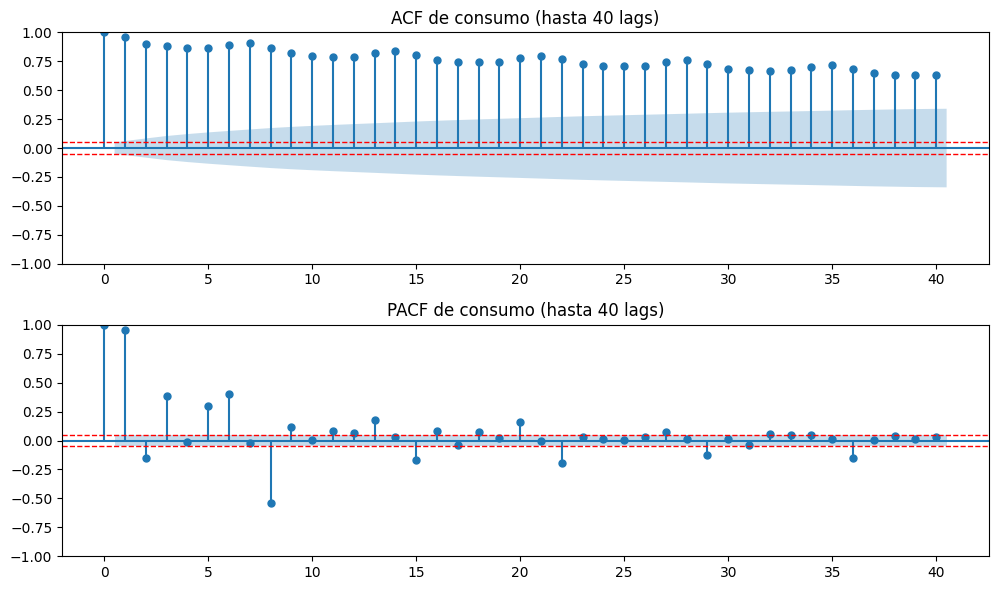

In [ ]:
## 6. ACF/PACF y selección de lags

fig_dir = Path(PATHS["out_figs"])
csv_dir = Path(PATHS["out_csv"])

# Serie diaria
s = df_daily.sort_values("fecha")["consumo"].astype(float).reset_index(drop=True)
N = len(s)
max_lag = 40
umbral = 1.96 / np.sqrt(N)   # banda aproximada de significación

# Valores numéricos
acf_vals  = sm_acf(s, nlags=max_lag, fft=True)
pacf_vals = sm_pacf(s, nlags=max_lag, method="ywadjusted")

# Candidatos por umbral
candidatos_acf  = [k for k in range(1, max_lag+1) if abs(acf_vals[k])  > umbral]
candidatos_pacf = [k for k in range(1, max_lag+1) if abs(pacf_vals[k]) > umbral]

# Heurística para sugerir hasta 6 lags
orden_preferencia = [1,2,3,4,5,6,7,14,21] + [k for k in range(8, max_lag+1)]
sugeridos = []
for k in orden_preferencia:
    if (k in candidatos_acf or k in candidatos_pacf) and k not in sugeridos:
        sugeridos.append(k)
    if len(sugeridos) >= 6:
        break

print(f"N = {N}, umbral ≈ {umbral:.3f}")
print("Candidatos ACF :", candidatos_acf)
print("Candidatos PACF:", candidatos_pacf)
print("Lags sugeridos :", sugeridos)

# Tabla ACF/PACF + marcas
lags = list(range(0, max_lag+1))
df_lags = pd.DataFrame({"lag": lags, "acf": acf_vals, "pacf": pacf_vals})
df_lags["sig_acf"]  = df_lags["acf"].abs()  > umbral
df_lags["sig_pacf"] = df_lags["pacf"].abs() > umbral
df_lags["sugerido"] = df_lags["lag"].isin(sugeridos)
df_lags.to_csv(csv_dir / "acf_pacf_lags.csv", index=False)

# Gráficos ACF/PACF (una sola figura)
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(s, lags=max_lag, ax=axes[0])
axes[0].set_title("ACF de consumo (hasta 40 lags)")
axes[0].axhline(+umbral, color="r", linestyle="--", linewidth=1)
axes[0].axhline(-umbral, color="r", linestyle="--", linewidth=1)

plot_pacf(s, lags=max_lag, ax=axes[1], method="ywadjusted")
axes[1].set_title("PACF de consumo (hasta 40 lags)")
axes[1].axhline(+umbral, color="r", linestyle="--", linewidth=1)
axes[1].axhline(-umbral, color="r", linestyle="--", linewidth=1)

plt.tight_layout()
fig.savefig(fig_dir / "acf_pacf_consumo.png", dpi=130, bbox_inches="tight")
plt.show()

**Conclusión ACF/PACF**

- Tamaño de la serie: **N = 1581** → banda de significación aprox.: **± 1.96 / √N ≈ 0.049**.
- **ACF**: valores significativos en casi todos los retardos (decay lento) → indica **alta persistencia** y componente estacional.
- **PACF**: picos claros en **1, 2, 3, 5, 6**; el semanal (**7**) no destaca en PACF pero sí se observa en ACF y en el análisis semanal del punto 5.

**Selección de lags para el modelo base (compacto):**
- `lags_base = [1, 2, 3, 7]`  
  (memoria corta + componente semanal)

**Alternativa para comparar (un poco más rica):**
- `lags_alt = [1, 2, 3, 5, 6, 7]`

Empezamos con `lags_base` por simplicidad y evitamos sobreajuste; si el rendimiento no es suficiente, probaremos `lags_alt`.

## 7.Dataset supervisado (lags → t+1…t+7)

Construimos el conjunto de aprendizaje para el **modelo base** usando solo lags del consumo.  
Elegimos: **lags = [1, 2, 3, 7]** y horizonte **H = 7** (t+1…t+7).

- Creamos columnas de **retardos**: `consumo_lag1`, `consumo_lag2`, `consumo_lag3`, `consumo_lag7`.
- Creamos las **dianas**: `y_t+1`, …, `y_t+7` (consumo desplazado hacia el futuro).
- Eliminamos filas con `NaN` generadas por los desplazamientos.
- Separamos **train** y **test** usando la **última semana real** como referencia de evaluación:
  - **test** = la **última fila** cuyo bloque de objetivos es **exactamente** la última semana observada,
  - **train** = el resto previo.

In [ ]:
## 7. Dataset supervisado (lags → t+1…t+7)

# 1) Partimos de df_daily con columnas: fecha, consumo, (meteo…)
base = df_daily.sort_values("fecha").reset_index(drop=True).copy()

# 2) Lags elegidos
lags = [1, 2, 3, 7]
for k in lags:
    base[f"consumo_lag{k}"] = base["consumo"].shift(k)

# 3) Objetivos t+1 … t+7
H = 7
for h in range(1, H+1):
    base[f"y_t+{h}"] = base["consumo"].shift(-h)

# 4) Limpiamos NaN generados por desplazamientos
superv = base.dropna(subset=[f"consumo_lag{k}" for k in lags] + [f"y_t+{h}" for h in range(1, H+1)]).copy()
superv = superv.reset_index(drop=True)

# 5) Semana de test (última semana observada)
last_date   = df_daily["fecha"].max()                 # último día real
test_start  = last_date - timedelta(days=6)           # primer día de la semana
anchor_test = test_start - timedelta(days=1)          # t = día anterior

# 6) Localizamos la fila cuya 'fecha' == anchor_test
fila_test = superv.index[superv["fecha"] == anchor_test]
assert len(fila_test) == 1, "No se encontró una única fila de test; revisa las fechas."
fila_test = int(fila_test[0])

# 7) Features / Targets y split
feat_cols = [f"consumo_lag{k}" for k in lags]
y_cols    = [f"y_t+{h}" for h in range(1, H+1)]

X = superv[feat_cols].values
Y = superv[y_cols].values
fechas_anchor = superv["fecha"].values  # fecha t (ancla)

X_train, Y_train = X[:fila_test], Y[:fila_test]
X_test,  Y_test  = X[fila_test:fila_test+1], Y[fila_test:fila_test+1]
fecha_ancla_test = pd.to_datetime(fechas_anchor[fila_test])

print("Supervisado total:", superv.shape[0], "filas")
print("Features:", feat_cols)
print("Targets :", y_cols)
print("\nSplit:")
print(" - Train:", X_train.shape, Y_train.shape)
print(" - Test :", X_test.shape,  Y_test.shape)
print("Fecha ancla de test (t):", fecha_ancla_test.date(),
      "→ objetivos son del", (fecha_ancla_test + timedelta(days=1)).date(),
      "al", (fecha_ancla_test + timedelta(days=7)).date())

# --- Guardado para la entrega ---
proc_dir = Path(PATHS["data_processed"])
superv_path = proc_dir / "supervisado_base_lags.csv"
meta_path   = proc_dir / "supervisado_meta.json"

superv.to_csv(superv_path, index=False)

meta = {
    "lags": lags,
    "horizonte": H,
    "anchor_test": str(fecha_ancla_test.date()),
    "fila_test": int(fila_test),
    "feat_cols": feat_cols,
    "y_cols": y_cols,
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0])
}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("\nGuardado:", superv_path)
print("Guardado:", meta_path)

Supervisado total: 1567 filas
Features: ['consumo_lag1', 'consumo_lag2', 'consumo_lag3', 'consumo_lag7']
Targets : ['y_t+1', 'y_t+2', 'y_t+3', 'y_t+4', 'y_t+5', 'y_t+6', 'y_t+7']

Split:
 - Train: (1566, 4) (1566, 7)
 - Test : (1, 4) (1, 7)
Fecha ancla de test (t): 2022-12-24 → objetivos son del 2022-12-25 al 2022-12-31

Guardado: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/data/processed/supervisado_base_lags.csv
Guardado: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/data/processed/supervisado_meta.json


## 8.Modelo base (lags de consumo) — Keras

Entrenamos una red densa sencilla con entrada de 4 lags `[1,2,3,7]` y salida vector de tamaño 7 (t+1…t+7).  
Estandarizamos **solo las features** con `StandardScaler` ajustado **en train** (sin fuga de información).  
Evaluamos en la **última semana** (test) con **MAE** y **RMSE**, y mostramos predicción vs. real por día.

In [ ]:
## 8. Modelo base (lags de consumo) — Keras + guardado/carga (RUN_MODELING)

csv_dir = Path(PATHS["out_csv"])


def rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))

pred_path    = csv_dir / "base_pred_test.csv"
metrics_path = csv_dir / "base_metrics.json"
history_path = csv_dir / "history_model_base.csv"

if RUN_MODELING:
    # 1) Escalado SOLO de X (entrenado en train)
    scalerX   = StandardScaler()
    X_train_s = scalerX.fit_transform(X_train)
    X_test_s  = scalerX.transform(X_test)

    # 2) Definición del modelo (API funcional)
    tf.keras.utils.set_random_seed(42)
    inp = Input(shape=(X_train_s.shape[1],), name="lags_input")  # (4,)
    x   = layers.Dense(32, activation="relu")(inp)
    x   = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(7, name="y_hat")(x)  # t+1..t+7
    model = Model(inputs=inp, outputs=out, name="modelo_base_lags")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=["mae"])

    # 3) Entrenamiento (sin validación explícita; enunciado)
    hist = model.fit(
        X_train_s, Y_train,
        epochs=200,
        batch_size=32,
        shuffle=False,
        verbose=0
    )

    # 4) Predicción en la última semana (test)
    y_pred = model.predict(X_test_s, verbose=0)[0]   # (7,)
    y_true = Y_test[0]                                # (7,)

    # 5) Métricas MAE/RMSE globales y por horizonte
    mae_global  = float(mean_absolute_error(y_true, y_pred))
    rmse_global = rmse(y_true, y_pred)

    # 6) Tabla legible y guardado
    fechas_semana = [(fecha_ancla_test + pd.Timedelta(days=i+1)).date() for i in range(7)]
    print("Predicción de la última semana (modelo base)")
    rows = []
    for d, yt, yp in zip(fechas_semana, y_true, y_pred):
        err = abs(yt-yp)
        rows.append({"fecha": str(d), "real": float(yt), "pred": float(yp), "error_abs": float(err)})
        print(f"  {d}: real={yt:8.2f} | pred={yp:8.2f} | error={err:7.2f}")

    print("\nMAE global (7 días): ", f"{mae_global:.2f}")
    print("RMSE global (7 días):", f"{rmse_global:.2f}")

    # Guardar artefactos para la entrega
    pd.DataFrame(rows).to_csv(pred_path, index=False)
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump({"mae_global": mae_global, "rmse_global": rmse_global}, f, ensure_ascii=False, indent=2)
    pd.DataFrame(hist.history).assign(epoch=lambda d: d.index+1)[["epoch","loss","mae"]].to_csv(history_path, index=False)

else:
    # CARGA de artefactos ya generados (no reentrena)
    if not (pred_path.exists() and metrics_path.exists()):
        raise FileNotFoundError(
            "Faltan artefactos del modelo base para el modo entrega.\n"
            f"Esperado: {pred_path.name} y {metrics_path.name} en {csv_dir}.\n"
            "Ejecuta una vez con RUN_MODELING=True para generarlos."
        )

    df_pred = pd.read_csv(pred_path)
    with open(metrics_path, "r", encoding="utf-8") as f:
        mets = json.load(f)

    print("Predicción de la última semana (modelo base) [CARGADA]")
    for _, r in df_pred.iterrows():
        d, yt, yp, err = r["fecha"], r["real"], r["pred"], r["error_abs"]
        print(f"  {d}: real={yt:8.2f} | pred={yp:8.2f} | error={err:7.2f}")

    print("\nMAE global (7 días): ", f"{mets['mae_global']:.2f}")
    print("RMSE global (7 días):", f"{mets['rmse_global']:.2f}")

Predicción de la última semana (modelo base) [CARGADA]
  2022-12-25: real=  353.00 | pred=  538.12 | error= 185.12
  2022-12-26: real=  430.00 | pred=  538.87 | error= 108.87
  2022-12-27: real=  499.00 | pred=  538.93 | error=  39.93
  2022-12-28: real=  497.00 | pred=  538.32 | error=  41.32
  2022-12-29: real=  491.00 | pred=  537.94 | error=  46.94
  2022-12-30: real=  445.00 | pred=  537.26 | error=  92.26
  2022-12-31: real=  384.00 | pred=  538.12 | error= 154.12

MAE global (7 días):  95.51
RMSE global (7 días): 109.47


## 9.Modelo extendido (lags + meteorología) — Keras

Ampliamos las entradas añadiendo variables diarias de meteo en t: `tmed`, `tmax_dia`, `tmin_dia`, `prec_dia`, `vmax_dia`, `inso_dia`.  
Mantenemos el mismo objetivo multi-salida (`t+1…t+7`) y la misma partición (última semana como test).

In [ ]:
## 9. Modelo extendido (lags + meteorología) — Keras + guardado/carga (RUN_MODELING)

csv_dir = Path(PATHS["out_csv"])

# 9.1 Dataset supervisado extendido
feat_lags    = [f"consumo_lag{k}" for k in [1, 2, 3, 7]]
feat_meteo   = ["tmed", "tmax_dia", "tmin_dia", "prec_dia", "vmax_dia", "inso_dia"]
feat_cols_ext = feat_lags + feat_meteo
targets      = [f"y_t+{h}" for h in range(1, 8)]

superv_ext = base.dropna(subset=feat_lags + targets).copy().reset_index(drop=True)

# Misma fila de test definida en el punto 7
fila_test = superv_ext.index[superv_ext["fecha"] == anchor_test]
assert len(fila_test) == 1, "No se encontró exactamente una fila de test."
fila_test = int(fila_test[0])

X_ext = superv_ext[feat_cols_ext].values
Y_ext = superv_ext[targets].values
X_train_ext, Y_train_ext = X_ext[:fila_test], Y_ext[:fila_test]
X_test_ext,  Y_test_ext  = X_ext[fila_test:fila_test+1], Y_ext[fila_test:fila_test+1]

# Escalado SOLO de X (ajustado en train)
scalerX_ext   = StandardScaler()
X_train_ext_s = scalerX_ext.fit_transform(X_train_ext)
X_test_ext_s  = scalerX_ext.transform(X_test_ext)

print("Entradas extendidas:", feat_cols_ext)
print("Train:", X_train_ext_s.shape, Y_train_ext.shape, "| Test:", X_test_ext_s.shape, Y_test_ext.shape)

# 9.2 Entrenamiento y evaluación (con guardado/carga)
pred_path    = csv_dir / "ext_pred_test.csv"
metrics_path = csv_dir / "ext_metrics.json"
history_path = csv_dir / "history_model_ext.csv"

def rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))

if RUN_MODELING:
    tf.keras.utils.set_random_seed(42)

    inp = Input(shape=(len(feat_cols_ext),), name="lags_meteo_input")
    x   = layers.Dense(64, activation="relu")(inp)
    x   = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(7, name="y_hat")(x)

    model_ext = Model(inp, out, name="modelo_ext_lags_meteo")
    model_ext.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss="mse", metrics=["mae"])

    hist = model_ext.fit(
        X_train_ext_s, Y_train_ext,
        epochs=250, batch_size=32, shuffle=False, verbose=0
    )

    # Predicción en la última semana (test)
    y_pred_ext = model_ext.predict(X_test_ext_s, verbose=0)[0]
    y_true_ext = Y_test_ext[0]

    mae_g  = float(mean_absolute_error(y_true_ext, y_pred_ext))
    rmse_g = rmse(y_true_ext, y_pred_ext)

    fechas_semana = [(anchor_test + pd.Timedelta(days=i+1)).date() for i in range(7)]
    print("Predicción de la última semana (modelo extendido)")
    rows = []
    for d, yt, yp in zip(fechas_semana, y_true_ext, y_pred_ext):
        err = abs(yt-yp)
        rows.append({"fecha": str(d), "real": float(yt), "pred": float(yp), "error_abs": float(err)})
        print(f"  {d}: real={yt:8.2f} | pred={yp:8.2f} | error={err:7.2f}")

    print("\nMAE global (7 días): ", f"{mae_g:.2f}")
    print("RMSE global (7 días):", f"{rmse_g:.2f}")

    # Guardado para la entrega
    pd.DataFrame(rows).to_csv(pred_path, index=False)
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump({"mae_global": mae_g, "rmse_global": rmse_g}, f, ensure_ascii=False, indent=2)
    pd.DataFrame(hist.history).assign(epoch=lambda d: d.index+1)[["epoch","loss","mae"]].to_csv(history_path, index=False)

else:
    # CARGA en modo entrega
    if not (pred_path.exists() and metrics_path.exists()):
        raise FileNotFoundError(
            "Faltan artefactos del modelo extendido para el modo entrega.\n"
            f"Esperado: {pred_path.name} y {metrics_path.name} en {csv_dir}.\n"
            "Ejecuta una vez con RUN_MODELING=True para generarlos."
        )

    df_pred = pd.read_csv(pred_path)
    with open(metrics_path, "r", encoding="utf-8") as f:
        mets = json.load(f)

    print("Predicción de la última semana (modelo extendido) [CARGADA]")
    for _, r in df_pred.iterrows():
        d, yt, yp, err = r["fecha"], r["real"], r["pred"], r["error_abs"]
        print(f"  {d}: real={yt:8.2f} | pred={yp:8.2f} | error={err:7.2f}")

    print("\nMAE global (7 días): ", f"{mets['mae_global']:.2f}")
    print("RMSE global (7 días):", f"{mets['rmse_global']:.2f}")

Entradas extendidas: ['consumo_lag1', 'consumo_lag2', 'consumo_lag3', 'consumo_lag7', 'tmed', 'tmax_dia', 'tmin_dia', 'prec_dia', 'vmax_dia', 'inso_dia']
Train: (1566, 10) (1566, 7) | Test: (1, 10) (1, 7)
Predicción de la última semana (modelo extendido) [CARGADA]
  2022-12-25: real=  353.00 | pred=  544.98 | error= 191.98
  2022-12-26: real=  430.00 | pred=  571.39 | error= 141.39
  2022-12-27: real=  499.00 | pred=  592.48 | error=  93.48
  2022-12-28: real=  497.00 | pred=  596.46 | error=  99.46
  2022-12-29: real=  491.00 | pred=  564.54 | error=  73.54
  2022-12-30: real=  445.00 | pred=  530.13 | error=  85.13
  2022-12-31: real=  384.00 | pred=  534.01 | error= 150.01

MAE global (7 días):  119.28
RMSE global (7 días): 125.72


## 10.Evaluación comparativa (MAE, RMSE) y pronóstico de la semana final

Comparamos los dos modelos sobre la **última semana observada** (t+1…t+7). Mostramos una tabla día a día (real vs. predicción) y un resumen de métricas **MAE** y **RMSE**.

In [ ]:
## 10. Evaluación comparativa (MAE, RMSE) y pronóstico de la semana final
csv_dir = Path(PATHS["out_csv"])

# Cargamos predicciones guardadas (puntos 8 y 9)
df_b = pd.read_csv(csv_dir / "base_pred_test.csv")  # columnas: fecha, real, pred, error_abs
df_e = pd.read_csv(csv_dir / "ext_pred_test.csv")   # columnas: fecha, real, pred, error_abs

# Unimos por fecha
df_eval = df_b.merge(
    df_e[["fecha","pred"]].rename(columns={"pred":"pred_ext"}),
    on="fecha", how="inner"
).rename(columns={"pred":"pred_base"})

# Errores absolutos
df_eval["err_base"] = (df_eval["pred_base"] - df_eval["real"]).abs()
df_eval["err_ext"]  = (df_eval["pred_ext"]  - df_eval["real"]).abs()

# Métricas (7 días)
def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
mae_base  = float(mean_absolute_error(df_eval["real"], df_eval["pred_base"]))
rmse_base = rmse(df_eval["real"], df_eval["pred_base"])
mae_ext   = float(mean_absolute_error(df_eval["real"], df_eval["pred_ext"]))
rmse_ext  = rmse(df_eval["real"], df_eval["pred_ext"])

df_metrics = pd.DataFrame({
    "modelo": ["base_lags", "extendido_lags+meteo"],
    "MAE":    [mae_base, mae_ext],
    "RMSE":   [rmse_base, rmse_ext],
}).round(2)

# Guardado
df_eval.to_csv(csv_dir / "comparativa_semana_final.csv", index=False)
df_metrics.to_csv(csv_dir / "metrics_comparativa.csv", index=False)

# Salida legible
print("Tabla comparativa (semana final):")
print(df_eval.to_string(index=False))
print("\nMétricas globales (7 días):")
print(df_metrics.to_string(index=False))
print("\nCSV guardados en:", csv_dir)

Tabla comparativa (semana final):
     fecha  real  pred_base  error_abs   pred_ext   err_base    err_ext
2022-12-25 353.0 538.118408 185.118408 544.978394 185.118408 191.978394
2022-12-26 430.0 538.869202 108.869202 571.392639 108.869202 141.392639
2022-12-27 499.0 538.928284  39.928284 592.479309  39.928284  93.479309
2022-12-28 497.0 538.318726  41.318726 596.459412  41.318726  99.459412
2022-12-29 491.0 537.944885  46.944885 564.535706  46.944885  73.535706
2022-12-30 445.0 537.259399  92.259399 530.134949  92.259399  85.134949
2022-12-31 384.0 538.115356 154.115356 534.008972 154.115356 150.008972

Métricas globales (7 días):
              modelo    MAE   RMSE
           base_lags  95.51 109.47
extendido_lags+meteo 119.28 125.72

CSV guardados en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/outputs/csv


### 10.1Conclusiones de la comparación

- **El modelo base (lags [1,2,3,7]) supera al extendido** en la semana final:  
  tus resultados muestran **MAE≈95.5 / RMSE≈109.5** (base) frente a **MAE≈119.3 / RMSE≈125.7** (extendido).
- **Por qué el extendido no mejora aquí:** esa semana (Navidad) tiene **caídas por efecto calendario (festivos/fin de semana)** que los lags sí capturan parcialmente (al mirar el pasado inmediato), pero la **meteorología empuja en sentido opuesto** (frío ⇒ subiría el consumo). Sin una señal explícita de **festivo** o **día de la semana**, el modelo extendido tiende a **sobrestimar**.
- **Posibles mejoras**:
  - **Variables de calendario**: `dow` (día de la semana), `fin_de_semana`, `festivo` (España).  


## 11.Anexo — Variables de calendario (festivos y semana)

En este anexo incorporamos **señales de calendario** para capturar caídas de consumo no explicadas por la temperatura: **día de la semana**, **fin de semana** y **festivos nacionales en España**. El objetivo es comprobar si estas variables mejoran la **predicción de la última semana** frente a los modelos previos (solo lags y lags+meteo).

**Qué haremos**
- Añadimos dummies de calendario a `df_daily` (sin tocar el resto del flujo).
- Rehacemos el **dataset supervisado** incluyendo estas entradas.
- Entrenamos un **modelo extendido + calendario** y comparamos **MAE/RMSE** con los modelos anteriores.

**Impacto esperado**
- Mejorar días especiales (festivos y fines de semana), donde el modelo sin calendario tiende a **sobrestimar**.


### 11.1.Instalación e importaciones específicas

Instalamos la librería `holidays` y cargamos las dependencias que usaremos para marcar **festivos nacionales de España**. Verificamos la versión instalada y el rango temporal de `df_daily` para preparar el siguiente punto.

In [ ]:
# Instalación (solo una vez por sesión de Colab)
%pip -q install holidays

# Importaciones específicas para el anexo
import holidays

# Comprobaciones informativas
print("holidays versión:", holidays.__version__)
print("Rango de años en df_daily:",
      int(df_daily["fecha"].dt.year.min()), "→", int(df_daily["fecha"].dt.year.max()))

holidays versión: 0.78
Rango de años en df_daily: 2018 → 2022


### 11.2.Calendario de festivos (España, 2018–2022)

Construimos el calendario de **festivos nacionales en España** para los años presentes en `df_daily` (2018–2022). Después verificamos algunas fechas clave (Navidad, Año Nuevo, Reyes, Constitución, Inmaculada) y contamos cuántos festivos caen dentro del rango real del dataset (2018-09-01 → 2022-12-31).

In [ ]:
# Años presentes en el dataset
years = sorted(df_daily["fecha"].dt.year.unique().tolist())
print("Años a cubrir:", years)

# Festivos de España para esos años
es_holidays = holidays.Spain(years=years)

# Festivos que caen dentro del rango real del dataset
start, end = df_daily["fecha"].min().date(), df_daily["fecha"].max().date()
festivos_periodo = sorted([d for d in es_holidays if (d >= start and d <= end)])
print(f"Festivos en el periodo {start} → {end}: {len(festivos_periodo)} días")

# Mostrar 10 primeros festivos del periodo (fecha → nombre)
for d in festivos_periodo[:10]:
    print(f"  {d} → {es_holidays[d]}")

# Comprobaciones puntuales (deben estar marcadas como festivo)
check_dates = [
    "2018-12-25", "2019-01-01", "2019-01-06",
    "2022-12-06", "2022-12-08", "2022-12-25"
]
print("\nVerificación de fechas clave:")
for s in check_dates:
    d = pd.to_datetime(s).date()
    print(f"  {d} →", es_holidays.get(d, "no festivo"))

# Guardado del listado de festivos nacionales del periodo
out_csv = Path(PATHS["out_csv"])
fest_df = pd.DataFrame({
    "fecha": festivos_periodo,
    "nombre": [es_holidays[d] for d in festivos_periodo]
})
fest_df.to_csv(out_csv / "festivos_nacionales_periodo.csv", index=False)
print("Guardado:", out_csv / "festivos_nacionales_periodo.csv")

Años a cubrir: [2018, 2019, 2020, 2021, 2022]
Festivos en el periodo 2018-09-01 → 2022-12-31: 38 días
  2018-10-12 → National Day
  2018-11-01 → All Saints' Day
  2018-12-06 → Constitution Day
  2018-12-08 → Immaculate Conception
  2018-12-25 → Christmas Day
  2019-01-01 → New Year's Day
  2019-04-19 → Good Friday
  2019-05-01 → Labor Day
  2019-08-15 → Assumption Day
  2019-10-12 → National Day

Verificación de fechas clave:
  2018-12-25 → Christmas Day
  2019-01-01 → New Year's Day
  2019-01-06 → no festivo
  2022-12-06 → Constitution Day
  2022-12-08 → Immaculate Conception
  2022-12-25 → no festivo
Guardado: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/outputs/csv/festivos_nacionales_periodo.csv


### 11.3.Enriquecimiento con variables de calendario (sin festivos autonómicos)

Añadimos señales de calendario a `df_daily` para capturar patrones no explicados por la meteorología:
- `dow`: día de la semana (0=Lun … 6=Dom).
- `es_fin_de_semana`: 1 si Sábado o Domingo, 0 en caso contrario.
- `es_festivo_nacional`: 1 si el día es festivo **nacional** en España, 0 si no. *(No incluimos festivos autonómicos.)*
- `festivo_efecto`: 1 si **festivo nacional** **o** **domingo**. Esto ayuda cuando un festivo cae en domingo, que la librería nacional no marca.

Mostramos un resumen de conteos y una ventana de fechas alrededor de Navidad 2022 para comprobar que las banderas quedan bien.

In [ ]:
# Aseguramos orden temporal
df_daily = df_daily.sort_values("fecha").reset_index(drop=True).copy()

# 1) Día de la semana y fin de semana
df_daily["dow"] = df_daily["fecha"].dt.dayofweek             # 0=Lun ... 6=Dom
df_daily["es_fin_de_semana"] = (df_daily["dow"] >= 5).astype("int8")

# 2) Festivo nacional (España, sin autonómicos)
years = sorted(df_daily["fecha"].dt.year.unique().tolist())
es_holidays = holidays.Spain(years=years)
df_daily["es_festivo_nacional"] = df_daily["fecha"].dt.date.map(lambda d: int(d in es_holidays)).astype("int8")

# 3) Festivo con efecto (festivo nacional O domingo)
df_daily["festivo_efecto"] = np.where(
    (df_daily["es_festivo_nacional"] == 1) | (df_daily["dow"] == 6), 1, 0
).astype("int8")

# Resumen rápido
print("Conteos:")
print(" - es_fin_de_semana=1      :", int(df_daily["es_fin_de_semana"].sum()))
print(" - es_festivo_nacional=1   :", int(df_daily["es_festivo_nacional"].sum()))
print(" - festivo_efecto=1        :", int(df_daily["festivo_efecto"].sum()))

# Ventana de comprobación alrededor de Navidad 2022
mask_nav = (df_daily["fecha"] >= "2022-12-20") & (df_daily["fecha"] <= "2023-01-02")
cols_show = ["fecha","dow","es_fin_de_semana","es_festivo_nacional","festivo_efecto","consumo"]
print("\nComprobación (Navidad 2022):")
print(df_daily.loc[mask_nav, cols_show].to_string(index=False))

# Guardado del df_daily enriquecido con calendario
proc_dir = Path(PATHS["data_processed"])
proc_dir.mkdir(parents=True, exist_ok=True)
df_daily.to_csv(proc_dir / "df_daily_calendar.csv", index=False)
print("Guardado:", proc_dir / "df_daily_calendar.csv")

Conteos:
 - es_fin_de_semana=1      : 452
 - es_festivo_nacional=1   : 38
 - festivo_efecto=1        : 263

Comprobación (Navidad 2022):
     fecha  dow  es_fin_de_semana  es_festivo_nacional  festivo_efecto  consumo
2022-12-20    1                 0                    0               0    654.0
2022-12-21    2                 0                    0               0    609.0
2022-12-22    3                 0                    0               0    560.0
2022-12-23    4                 0                    0               0    480.0
2022-12-24    5                 1                    0               0    382.0
2022-12-25    6                 1                    0               1    353.0
2022-12-26    0                 0                    0               0    430.0
2022-12-27    1                 0                    0               0    499.0
2022-12-28    2                 0                    0               0    497.0
2022-12-29    3                 0                    0         

### 11.4.Dataset supervisado con calendario

Extendemos el dataset del punto 9 añadiendo **variables de calendario**:
- Señales **numéricas**: lags de consumo `[1,2,3,7]` + meteo diaria (`tmed`, `tmax_dia`, `tmin_dia`, `prec_dia`, `vmax_dia`, `inso_dia`).
- Señales **categóricas**: `es_fin_de_semana`, `es_festivo_nacional`, `festivo_efecto` y **one-hot de `dow`** (`dow_0`…`dow_6`).

Escalamos **solo** las variables numéricas con `StandardScaler` ajustado en **train**. Mantenemos **la misma fila de test (anchor_test)** que en el punto 7 para evaluar la última semana.

In [ ]:
# 11.4 Dataset supervisado con calendario (mismas fechas ancla que antes)

# 1) Partimos de 'base' (lags/targets) y añadimos calendario desde df_daily
feat_lags   = [f"consumo_lag{k}" for k in [1, 2, 3, 7]]
feat_meteo  = ["tmed","tmax_dia","tmin_dia","prec_dia","vmax_dia","inso_dia"]
targets     = [f"y_t+{h}" for h in range(1, 8)]
cal_cols    = ["dow","es_fin_de_semana","es_festivo_nacional","festivo_efecto"]

# Filas válidas (sin NaN en lags/targets)
superv_cal = base.dropna(subset=feat_lags + targets).copy().reset_index(drop=True)

# Merge de calendario por fecha (sin autonómicos)
superv_cal = superv_cal.merge(
    df_daily[["fecha"] + cal_cols],
    on="fecha", how="left"
)

# One-hot de 'dow' (0..6)
dow_ohe = pd.get_dummies(superv_cal["dow"].astype(int), prefix="dow", dtype="int8")
superv_cal = pd.concat([superv_cal.drop(columns=["dow"]), dow_ohe], axis=1)

# 2) Columnas finales de entrada
dow_cols   = sorted([c for c in superv_cal.columns if c.startswith("dow_")])
num_cols   = feat_lags + feat_meteo
cat_cols   = ["es_fin_de_semana","es_festivo_nacional","festivo_efecto"] + dow_cols
feat_cols  = num_cols + cat_cols

# 3) Localizamos la MISMA fila de test (anchor_test definido en el p.7)
fila_test = superv_cal.index[superv_cal["fecha"] == anchor_test]
assert len(fila_test) == 1, "No se encontró exactamente una fila de test."
fila_test = int(fila_test[0])

# 4) Construimos X/Y y split temporal
X_num = superv_cal[num_cols].values
X_cat = superv_cal[cat_cols].values  # dummies 0/1

Y_all = superv_cal[targets].values

X_num_train, X_num_test = X_num[:fila_test], X_num[fila_test:fila_test+1]
X_cat_train, X_cat_test = X_cat[:fila_test], X_cat[fila_test:fila_test+1]
Y_train_cal, Y_test_cal = Y_all[:fila_test], Y_all[fila_test:fila_test+1]

# 5) Escalado SOLO de numéricas (train fit) y ensamblado final
scaler_num = StandardScaler()
X_num_train_s = scaler_num.fit_transform(X_num_train)
X_num_test_s  = scaler_num.transform(X_num_test)

X_train_cal = np.hstack([X_num_train_s, X_cat_train])
X_test_cal  = np.hstack([X_num_test_s,  X_cat_test])

print("Features numéricas:", num_cols)
print("Features categóricas:", cat_cols)
print("Total features:", len(feat_cols), "| Num:", len(num_cols), "| Cat:", len(cat_cols))
print("Train:", X_train_cal.shape, Y_train_cal.shape, "| Test:", X_test_cal.shape, Y_test_cal.shape)

Features numéricas: ['consumo_lag1', 'consumo_lag2', 'consumo_lag3', 'consumo_lag7', 'tmed', 'tmax_dia', 'tmin_dia', 'prec_dia', 'vmax_dia', 'inso_dia']
Features categóricas: ['es_fin_de_semana', 'es_festivo_nacional', 'festivo_efecto', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
Total features: 20 | Num: 10 | Cat: 10
Train: (1566, 20) (1566, 7) | Test: (1, 20) (1, 7)


### 11.5.Modelo extendido + calendario (Keras) y evaluación

Entrenamos una red densa con **20 entradas** (lags + meteo + calendario) y salida **7** (t+1…t+7).  
Mantenemos el entrenamiento sin validación explícita (como en el resto del cuaderno) y evaluamos sobre la **última semana**.

In [ ]:
## 11.5. Modelo lags + meteo + calendario — guardado/carga (RUN_MODELING)

csv_dir = Path(PATHS["out_csv"])
pred_path    = csv_dir / "cal_pred_test.csv"
metrics_path = csv_dir / "cal_metrics.json"
history_path = csv_dir / "history_model_cal.csv"

def rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))

if RUN_MODELING:
    tf.keras.utils.set_random_seed(42)

    inp = Input(shape=(X_train_cal.shape[1],), name="input_lags_meteo_cal")
    x   = layers.Dense(64, activation="relu")(inp)
    x   = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(7, name="y_hat")(x)

    model_cal = Model(inp, out, name="modelo_lags_meteo_cal")
    model_cal.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])

    hist = model_cal.fit(
        X_train_cal, Y_train_cal,
        epochs=250, batch_size=32, shuffle=False, verbose=0
    )

    # Predicción en la última semana (test)
    y_pred_cal = model_cal.predict(X_test_cal, verbose=0)[0]
    y_true_cal = Y_test_cal[0]

    mae_g  = float(mean_absolute_error(y_true_cal, y_pred_cal))
    rmse_g = rmse(y_true_cal, y_pred_cal)

    # Tabla legible y guardado
    fechas_semana = [(anchor_test + pd.Timedelta(days=i+1)).date() for i in range(7)]
    print("Predicción de la última semana (modelo lags + meteo + calendario)")
    rows = []
    for d, yt, yp in zip(fechas_semana, y_true_cal, y_pred_cal):
        err = abs(yt-yp)
        rows.append({"fecha": str(d), "real": float(yt), "pred": float(yp), "error_abs": float(err)})
        print(f"  {d}: real={yt:8.2f} | pred={yp:8.2f} | error={err:7.2f}")

    print("\nMAE global (7 días): ", f"{mae_g:.2f}")
    print("RMSE global (7 días):", f"{rmse_g:.2f}")

    pd.DataFrame(rows).to_csv(pred_path, index=False)
    pd.DataFrame(hist.history).assign(epoch=lambda d: d.index+1)[["epoch","loss","mae"]].to_csv(history_path, index=False)
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump({"mae_global": mae_g, "rmse_global": rmse_g}, f, ensure_ascii=False, indent=2)

else:
    # Carga en modo entrega
    df_pred = pd.read_csv(pred_path)
    with open(metrics_path, "r", encoding="utf-8") as f:
        mets = json.load(f)

    print("Predicción de la última semana (modelo lags + meteo + calendario) [CARGADA]")
    for _, r in df_pred.iterrows():
        print(f"  {r['fecha']}: real={r['real']:8.2f} | pred={r['pred']:8.2f} | error={r['error_abs']:7.2f}")

    print("\nMAE global (7 días): ", f"{mets['mae_global']:.2f}")
    print("RMSE global (7 días):", f"{mets['rmse_global']:.2f}")

Predicción de la última semana (modelo lags + meteo + calendario) [CARGADA]
  2022-12-25: real=  353.00 | pred=  472.69 | error= 119.69
  2022-12-26: real=  430.00 | pred=  509.58 | error=  79.58
  2022-12-27: real=  499.00 | pred=  538.35 | error=  39.35
  2022-12-28: real=  497.00 | pred=  549.55 | error=  52.55
  2022-12-29: real=  491.00 | pred=  528.82 | error=  37.82
  2022-12-30: real=  445.00 | pred=  492.78 | error=  47.78
  2022-12-31: real=  384.00 | pred=  469.80 | error=  85.80

MAE global (7 días):  66.08
RMSE global (7 días): 71.76


In [ ]:
# === Guardado de artefactos para desplieguecon FastAPI SOLO si RUN_MODELING=True ===
MODELS_DIR = Path(PATHS["out_models"])
MODELS_DIR.mkdir(parents=True, exist_ok=True)

model_path     = MODELS_DIR / "ej2_model_lags_meteo_cal.keras"
scaler_path    = MODELS_DIR / "ej2_scaler_num.pkl"
feat_cols_path = MODELS_DIR / "ej2_feat_cols.json"
num_cols_path  = MODELS_DIR / "ej2_num_cols.json"
cat_cols_path  = MODELS_DIR / "ej2_cat_cols.json"

if RUN_MODELING:
    # model_cal (Keras), scaler_num (StandardScaler), feat_cols, num_cols, cat_cols
    required = ['model_cal', 'scaler_num', 'feat_cols', 'num_cols', 'cat_cols']
    missing = [name for name in required if name not in globals()]
    if missing:
        raise RuntimeError(
            "Faltan en memoria: " + ", ".join(missing) +
            ". Ejecuta la sección 11.5 antes de guardar artefactos."
        )

    # Guardar artefactos para despliegue
    model_cal.save(model_path)
    joblib.dump(scaler_num, scaler_path)
    feat_cols_path.write_text(json.dumps(feat_cols, ensure_ascii=False, indent=2), encoding="utf-8")
    num_cols_path.write_text(json.dumps(num_cols,  ensure_ascii=False, indent=2), encoding="utf-8")
    cat_cols_path.write_text(json.dumps(cat_cols,  ensure_ascii=False, indent=2), encoding="utf-8")

    print("✅ Artefactos guardados en:", MODELS_DIR)
else:
    print("Modo entrega (RUN_MODELING=False): no se guardan artefactos.")

## 12.Comparativa final (base vs. extendido vs. extendido+calendario) y conclusión

A continuación comparamos **MAE** y **RMSE** sobre la **última semana observada** para los tres enfoques:

1) **Base (lags)**  
2) **Extendido (lags + meteo)**  
3) **Extendido + calendario** (lags + meteo + dummies de semana/festivos nacionales)

**Conclusión.** Las variables de **calendario** mejoran de forma clara el rendimiento en la semana navideña: reducimos el error medio de ~95.5 (modelo base) a ~66.1. El modelo extendido solo con meteo no mejora en ese tramo (se ve penalizado por los festivos). Persisten errores altos en días muy atípicos (p. ej., 25 y 31 de diciembre), donde sería razonable añadir señales adicionales (p. ej., *víspera/post-festivo* o una bandera de *periodo_navidad*). Recordamos que aquí solo hemos incluido **festivos nacionales** (no autonómicos).

In [ ]:
## 12. Comparativa final (carga desde outputs/csv)

csv_dir = Path(PATHS["out_csv"])

# Cargamos predicciones guardadas
df_b = pd.read_csv(csv_dir / "base_pred_test.csv") .rename(columns={"pred":"pred_base"})
df_e = pd.read_csv(csv_dir / "ext_pred_test.csv")  .rename(columns={"pred":"pred_ext"})
df_c = pd.read_csv(csv_dir / "cal_pred_test.csv")  .rename(columns={"pred":"pred_cal"})

# Unimos por fecha; tomamos 'real' del modelo base
df_semana = (
    df_b[["fecha","real","pred_base"]]
    .merge(df_e[["fecha","pred_ext"]], on="fecha", how="inner")
    .merge(df_c[["fecha","pred_cal"]], on="fecha", how="inner")
)

# Errores absolutos por modelo
df_semana["err_base"] = (df_semana["pred_base"] - df_semana["real"]).abs()
df_semana["err_ext"]  = (df_semana["pred_ext"]  - df_semana["real"]).abs()
df_semana["err_cal"]  = (df_semana["pred_cal"]  - df_semana["real"]).abs()

# Métricas globales (7 días)
def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
mae_base,  rmse_base = float(mean_absolute_error(df_semana["real"], df_semana["pred_base"])), rmse(df_semana["real"], df_semana["pred_base"])
mae_ext,   rmse_ext  = float(mean_absolute_error(df_semana["real"], df_semana["pred_ext"])),  rmse(df_semana["real"], df_semana["pred_ext"])
mae_cal,   rmse_cal  = float(mean_absolute_error(df_semana["real"], df_semana["pred_cal"])),  rmse(df_semana["real"], df_semana["pred_cal"])

df_metrics_final = pd.DataFrame({
    "modelo": ["base_lags", "extendido_lags+meteo", "extendido_lags+meteo+calendario"],
    "MAE":    [mae_base, mae_ext, mae_cal],
    "RMSE":   [rmse_base, rmse_ext, rmse_cal],
}).round(2)

# Guardado
df_metrics_final.to_csv(csv_dir / "metrics_comparativa_final.csv", index=False)
df_semana.to_csv(csv_dir / "comparativa_semana_final_tres_modelos.csv", index=False)

# Salida legible
print("Métricas globales (7 días):")
print(df_metrics_final.to_string(index=False))
print("\nComparativa día a día (semana final):")
print(df_semana.round(2).to_string(index=False))
print("\nCSV guardados en:", csv_dir)

Métricas globales (7 días):
                         modelo    MAE   RMSE
                      base_lags  95.51 109.47
           extendido_lags+meteo 119.28 125.72
extendido_lags+meteo+calendario  66.08  71.76

Comparativa día a día (semana final):
     fecha  real  pred_base  pred_ext  pred_cal  err_base  err_ext  err_cal
2022-12-25 353.0     538.12    544.98    472.69    185.12   191.98   119.69
2022-12-26 430.0     538.87    571.39    509.58    108.87   141.39    79.58
2022-12-27 499.0     538.93    592.48    538.35     39.93    93.48    39.35
2022-12-28 497.0     538.32    596.46    549.55     41.32    99.46    52.55
2022-12-29 491.0     537.94    564.54    528.82     46.94    73.54    37.82
2022-12-30 445.0     537.26    530.13    492.78     92.26    85.13    47.78
2022-12-31 384.0     538.12    534.01    469.80    154.12   150.01    85.80

CSV guardados en: /content/drive/MyDrive/MASTER BIG DATA/md2_2025/ej2_prediccion_gas/outputs/csv


## 13.Despliegue del modelo (FastAPI + Swagger)

En este apartado documentamos el despliegue del **modelo final de la Sección 11.5** (*modelo_lags_meteo_cal*) como un servicio HTTP usando **FastAPI**, con documentación interactiva vía **Swagger UI**.

**Artefactos del modelo (generados previamente):**
- `outputs/models/ej2_model_lags_meteo_cal.keras`  ← modelo Keras
- `outputs/models/ej2_scaler_num.pkl`              ← `StandardScaler` (numéricas)
- `outputs/models/ej2_feat_cols.json`              ← orden exacto de features de entrada
- `outputs/models/ej2_num_cols.json`               ← listado de numéricas
- `outputs/models/ej2_cat_cols.json`               ← listado de categóricas (dummies)

**Script del servicio:**
- `outputs/models/main.py`  
  (Ubicado junto a los artefactos para que cargue sin cambios de ruta)

**Evidencias (capturas pantalla):**
- `docs/ej2_deployment/swagger_payload.png` ← Formulario de `/predict` con el JSON de ejemplo
- `docs/ej2_deployment/swagger_response.png`← Respuesta con las 7 predicciones (`y_hat`)

---

### 13.1. Arranque local del servicio

Desde una terminal, situados en la carpeta con los artefactos y `main.py`:

```bash
cd outputs/models

python3 -m venv .venv

source .venv/bin/activate

pip install fastapi uvicorn tensorflow

pandas numpy joblib scikit-learn

uvicorn main:app --reload